<a href="https://colab.research.google.com/github/canmike/lulc_semantic_segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Downloading .py Files

In [1]:
import requests
from pathlib import Path

def download_py(file_name:str, path:str=None):
  if path == None:
    path = "https://raw.githubusercontent.com/canmike/lulc_semantic_segmentation/main/" + file_name

  if Path(file_name).is_file():
    print(f"{file_name} already exists, skipping download")
  else:
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get(path)
    with open(file_name, "wb") as f:
      f.write(request.content)
    print(f"Downloaded {file_name}.")

In [2]:
download_py("utils.py")
download_py("visualization.py")
download_py("training.py")
download_py("dataset.py")

Downloaded utils.py.
Downloaded visualization.py.
Downloaded training.py.
Downloaded dataset.py.


# 2. Downloading Data

In [3]:
import gdown

id = "1Hf6Zz4MhL_X8bxNvGD7KOX4tlp2fcphj"
gdown.download_folder(id=id, quiet=True, use_cookies=False)

import zipfile
from pathlib import Path
import os

data_path = Path("C2Seg_AB/")
image_path = Path("data")

with zipfile.ZipFile(data_path / "C2Seg_AB.zip", "r") as zip_ref:
    print("Unzipping C2Seg_AB data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "C2Seg_AB.zip")

Unzipping C2Seg_AB data...


In [4]:
# import gdown

# id = "1FhV4kfQtyVj7Ni6cXYOv2PU67aGZK1gP"
# gdown.download_folder(id=id, quiet=True, use_cookies=False)

# import zipfile
# from pathlib import Path
# import os

# data_path = Path("C2Seg_BW")
# image_path = Path("data")

# with zipfile.ZipFile(data_path / "C2Seg_BW_train_msisar.zip", "r") as zip_ref:
#     print("Unzipping C2Seg_BW_train_msisar data...")
#     zip_ref.extractall(image_path)

# # Remove zip file
# os.remove(data_path / "C2Seg_BW_train_msisar.zip")

# 3. Setting Models

In [5]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

In [6]:
use_msi=True
use_sar=True
use_hsi=False
reduce_hsi=False
reduce_bands=20

in_channels = 0
if use_msi:
  in_channels += 4
if use_sar:
  in_channels += 2
if use_hsi:
  if reduce_hsi:
    in_channels += reduce_bands
  else:
    in_channels += 248

in_channels

6

In [7]:
!pip install -U segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3bcecf2f49531bd4156839628e287076bb8ad96224548a6aaa56af38f20407fa
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=a425c01e6ec6cc05c111cc8b3b9224db826322db31d9c07139ccf67b915cfce0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [8]:
import segmentation_models_pytorch as smp

model_unet_resnet101 = smp.UnetPlusPlus(
    encoder_name="resnet101",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=in_channels,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=14,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 64.2MB/s]


## 3.1 Setting up device agnostic code

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 4. Defining color-labels

In [10]:
import numpy as np
label_map = np.array([
      (0, 0, 0),          # 0 - Background (Black)
      (0, 0, 255),        # 1 - Surface water (Blue)
      (135, 206, 250),    # 2 - Street (Light Sky Blue)
      (255, 255, 0),      # 3 - Urban Fabric (Yellow)
      (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
      (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
      (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
      (255, 165, 0),      # 7 - Arable Land (Orange)
      (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
      (154, 205, 50),     # 9 - Pastures (Yellow Green)
      (34, 139, 34),      # 10 - Forests (Forest Green)
      (139, 69, 19),      # 11 - Shrub (Saddle Brown)
      (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
      (0, 255, 255),      # 13 - Inland wetlands (Cyan)
  ])


labels = [
    "Background", "Surface water", "Street", "Urban Fabric", "Industrial, commercial and transport",
    "Mine, dump, and construction sites", "Artificial, vegetated areas", "Arable Land",
    "Permanent Crops", "Pastures", "Forests", "Shrub", "Open spaces with no vegetation", "Inland wetlands"
]

# 5. Training Model

## 5.1 Splitting Train and Validation Data

In [11]:
data_count = 273
# data_count = 7138

In [12]:
from sklearn.model_selection import train_test_split
indexes = list(range(data_count))
train_idx, val_idx = train_test_split(indexes, train_size=0.85)

len(train_idx), len(val_idx)

(232, 41)

## 5.2 Creating DataLoaders

In [14]:
from dataset import SegmentationDataSet
from torch.utils import data
training_dataset = SegmentationDataSet(indexes=train_idx,
                                       #file_path= "/content/data/C2Seg_BW_train_msisar",
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

training_dataloader = data.DataLoader(dataset=training_dataset,
                                      batch_size=8,
                                      shuffle=True)
x, y = next(iter(training_dataloader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([8, 6, 128, 128]); type: torch.float32
x = min: -31.58401107788086; max: 7302.0
y = shape: torch.Size([8, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [15]:
val_dataset = SegmentationDataSet(indexes=val_idx,
                                       #file_path= "/content/data/C2Seg_BW_train_msisar",
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

val_dataloader = data.DataLoader(dataset=val_dataset,
                                      batch_size=8,
                                      shuffle=True)
x, y = next(iter(val_dataloader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([8, 6, 128, 128]); type: torch.float32
x = min: -31.58401107788086; max: 5514.0
y = shape: torch.Size([8, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


## 5.3 Training

In [16]:
from training import train
optimizer = optim.AdamW(model_unet_resnet101.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()
num_epochs=20

train(model_unet_resnet101, training_dataloader, val_dataloader, loss_fn, optimizer, num_epochs)

Epoch 1 | Train Loss: 2.8008 | Train Accuracy: 6.4085% | Train mIOU: 0.0226 | Train mF1: 0.0428
Epoch 1 | Val Loss: 2.6289   | Val Accuracy: 7.9407%   | Val mIOU: 0.0273   | Val mF1: 0.0503
----- Epoch Time: 14.69s -----
Epoch 2 | Train Loss: 2.5738 | Train Accuracy: 10.8412% | Train mIOU: 0.0360 | Train mF1: 0.0636
Epoch 2 | Val Loss: 2.4481   | Val Accuracy: 17.2919%   | Val mIOU: 0.0455   | Val mF1: 0.0761
----- Epoch Time: 6.16s -----
Epoch 3 | Train Loss: 2.4619 | Train Accuracy: 15.0299% | Train mIOU: 0.0514 | Train mF1: 0.0868
Epoch 3 | Val Loss: 2.4192   | Val Accuracy: 18.3965%   | Val mIOU: 0.0561   | Val mF1: 0.0907
----- Epoch Time: 6.31s -----
Epoch 4 | Train Loss: 2.3777 | Train Accuracy: 19.1681% | Train mIOU: 0.0651 | Train mF1: 0.1042
Epoch 4 | Val Loss: 2.3954   | Val Accuracy: 25.2637%   | Val mIOU: 0.0707   | Val mF1: 0.1101
----- Epoch Time: 6.22s -----


## 5.4 Visualizing Results

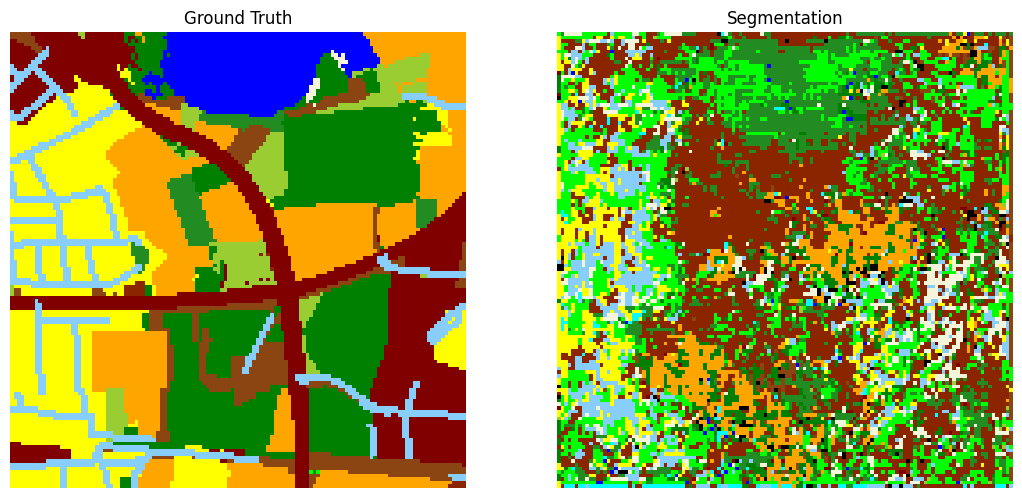

In [17]:
from visualization import predict_and_show
index = 13
predict_and_show(model_unet_resnet101, val_dataset, index)

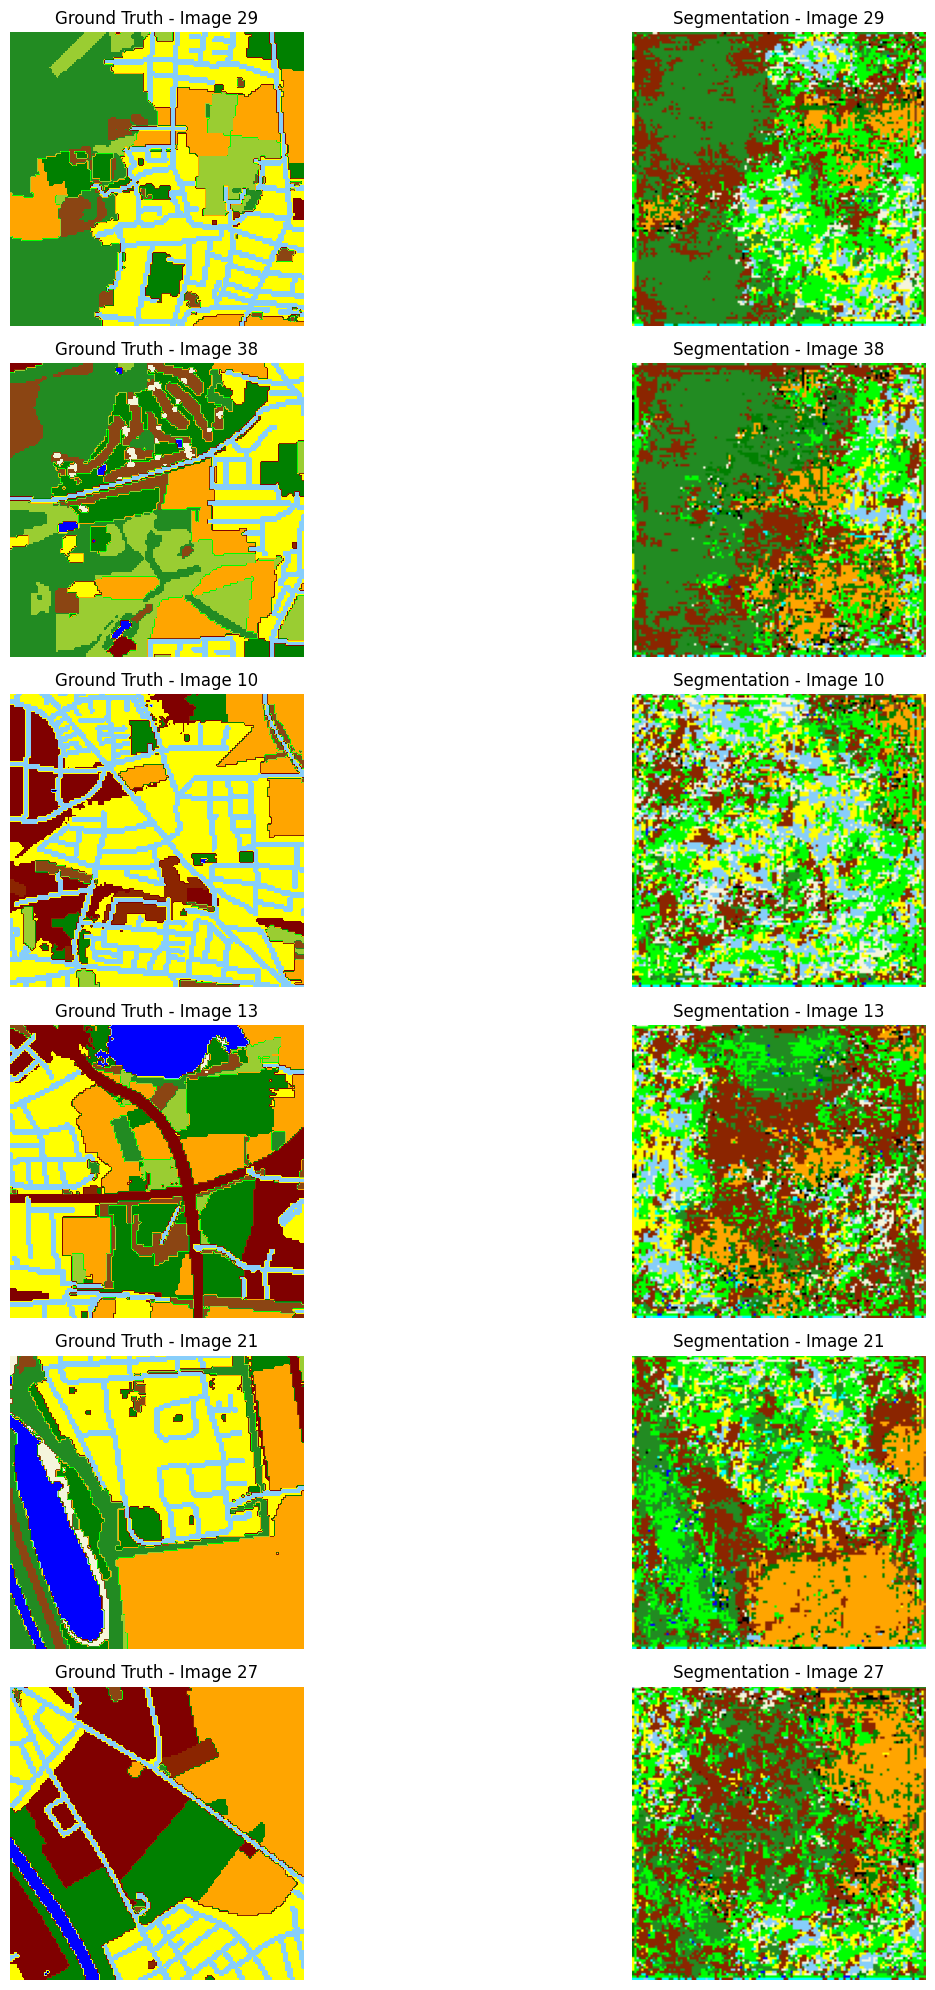

In [18]:
from visualization import predict_random_and_show
predict_random_and_show(model=model_unet_resnet101, dataset=val_dataset)

## 5.5 Save The Base Model

In [39]:
torch.save(model_unet_resnet101, "models/xx.pth")

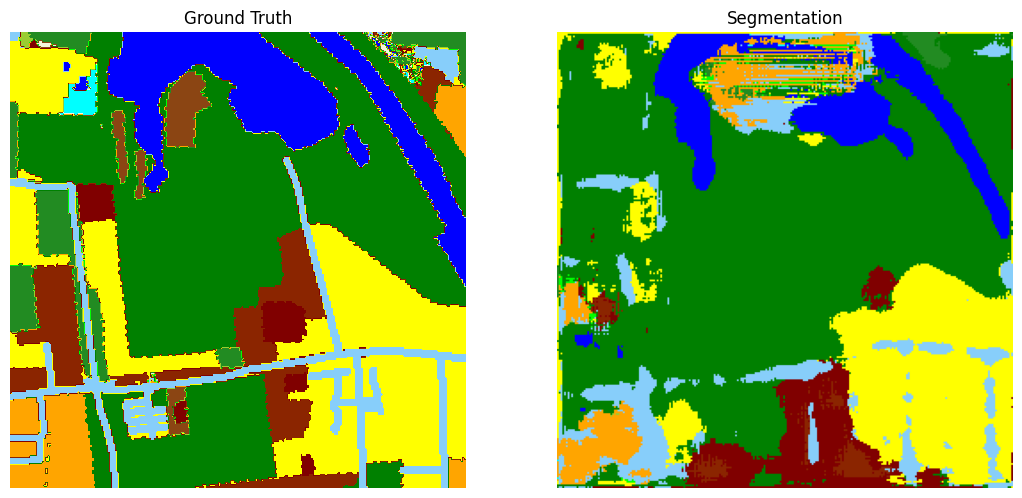

In [40]:
loaded_model = torch.load("models/xx.pth")
predict_and_show(loaded_model, val_dataset, 13)

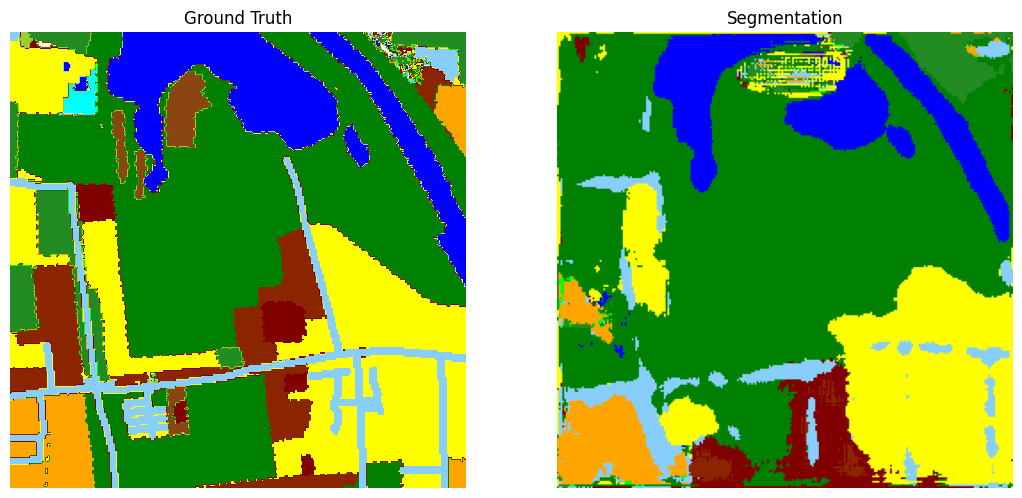

In [42]:
predict_and_show(model_unet_resnet101, val_dataset, 13)